# Sanity Check of FedLeak (Resize Generator), Lung & Colon Cancer (LC25000)

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=False`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_resize_showcase.ipynb`, with `resize_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:2")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
loader_iter = iter(trainloader)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

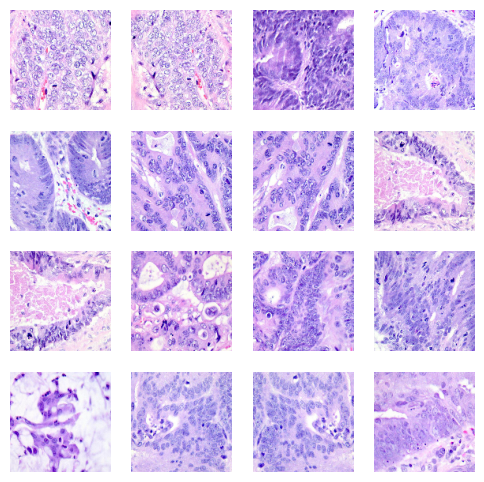

| It: 1 | Loss: -44.8810 | Time:   4.49s |


| It: 1001 | Loss: -60.5184 | Time: 611.87s |


| It: 2001 | Loss: -61.1205 | Time: 663.27s |


| It: 3001 | Loss: -61.3876 | Time: 658.11s |


| It: 4001 | Loss: -61.5389 | Time: 668.76s |


| It: 5001 | Loss: -61.6183 | Time: 672.59s |


| It: 6001 | Loss: -61.6877 | Time: 668.72s |


| It: 7001 | Loss: -61.7353 | Time: 666.69s |


| It: 8001 | Loss: -61.7686 | Time: 668.89s |


| It: 9001 | Loss: -61.7846 | Time: 667.27s |


| It: 1 | Loss: -43.3760 | Time:   0.68s |


| It: 1001 | Loss: -60.7680 | Time: 668.61s |


| It: 2001 | Loss: -61.2862 | Time: 667.19s |


| It: 3001 | Loss: -61.4987 | Time: 667.87s |


| It: 4001 | Loss: -61.6007 | Time: 669.22s |


| It: 5001 | Loss: -61.6694 | Time: 666.87s |


| It: 6001 | Loss: -61.7258 | Time: 668.34s |


| It: 7001 | Loss: -61.7666 | Time: 668.05s |


| It: 8001 | Loss: -61.7950 | Time: 666.21s |


| It: 9001 | Loss: -61.8090 | Time: 668.94s |


| It: 1 | Loss: -43.1619 | Time:   0.69s |


| It: 1001 | Loss: -60.6911 | Time: 670.92s |


| It: 2001 | Loss: -61.2736 | Time: 673.05s |


| It: 3001 | Loss: -61.4697 | Time: 671.78s |


| It: 4001 | Loss: -61.5805 | Time: 672.45s |


| It: 5001 | Loss: -61.6569 | Time: 673.53s |


| It: 6001 | Loss: -61.7150 | Time: 669.39s |


| It: 7001 | Loss: -61.7589 | Time: 668.10s |


| It: 8001 | Loss: -61.7881 | Time: 667.95s |


| It: 9001 | Loss: -61.8022 | Time: 671.53s |


| It: 1 | Loss: -43.2947 | Time:   0.69s |


| It: 1001 | Loss: -60.5913 | Time: 671.96s |


| It: 2001 | Loss: -61.2095 | Time: 666.09s |


| It: 3001 | Loss: -61.4333 | Time: 663.77s |


| It: 4001 | Loss: -61.5625 | Time: 667.80s |


| It: 5001 | Loss: -61.6481 | Time: 667.44s |


| It: 6001 | Loss: -61.7080 | Time: 667.85s |


| It: 7001 | Loss: -61.7545 | Time: 670.85s |


| It: 8001 | Loss: -61.7838 | Time: 669.85s |


| It: 9001 | Loss: -61.7985 | Time: 671.98s |


| It: 1 | Loss: -44.4607 | Time:   0.69s |


| It: 1001 | Loss: -60.9240 | Time: 670.90s |


| It: 2001 | Loss: -61.3162 | Time: 668.62s |


| It: 3001 | Loss: -61.5056 | Time: 659.71s |


| It: 4001 | Loss: -61.6055 | Time: 660.93s |


| It: 5001 | Loss: -61.6748 | Time: 668.77s |


| It: 6001 | Loss: -61.7333 | Time: 666.58s |


| It: 7001 | Loss: -61.7739 | Time: 667.50s |


| It: 8001 | Loss: -61.8003 | Time: 662.28s |


| It: 9001 | Loss: -61.8144 | Time: 661.85s |


BEST PSNR: 13.9606
MEDIAN PSNR: 13.2235
ALL PSNR: [11.5528, 13.7873, 13.9606, 13.5830, 13.5830]


<Figure size 400x300 with 0 Axes>

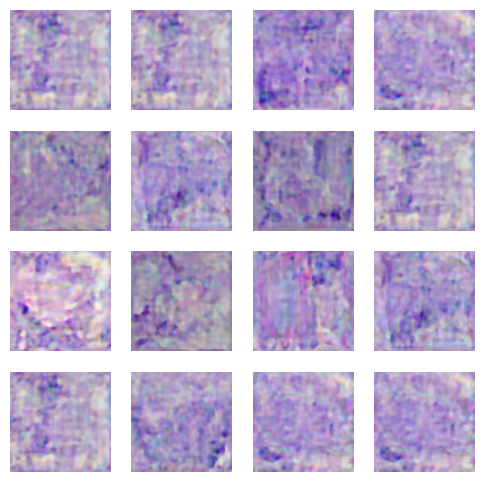

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

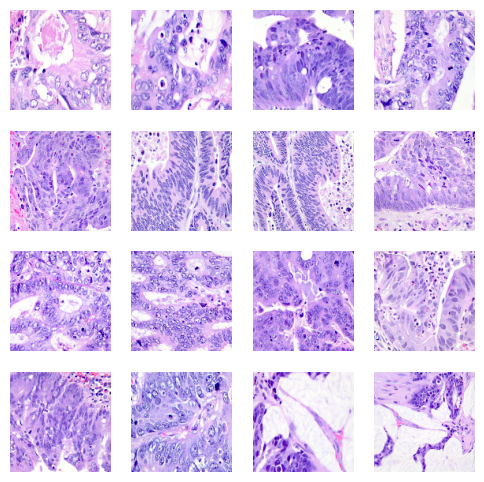

| It: 1 | Loss: -43.0209 | Time:   0.62s |


| It: 1001 | Loss: -60.6563 | Time: 662.58s |


| It: 2001 | Loss: -61.2808 | Time: 660.51s |


| It: 3001 | Loss: -61.4848 | Time: 647.41s |


| It: 4001 | Loss: -61.5986 | Time: 652.32s |


| It: 5001 | Loss: -61.6680 | Time: 646.61s |


| It: 6001 | Loss: -61.7231 | Time: 647.23s |


| It: 7001 | Loss: -61.7653 | Time: 654.52s |


| It: 8001 | Loss: -61.7921 | Time: 652.76s |


| It: 9001 | Loss: -61.8056 | Time: 653.80s |


| It: 1 | Loss: -42.3830 | Time:   0.68s |


| It: 1001 | Loss: -60.6879 | Time: 657.52s |


| It: 2001 | Loss: -61.2407 | Time: 654.14s |


| It: 3001 | Loss: -61.4501 | Time: 654.23s |


| It: 4001 | Loss: -61.5720 | Time: 658.83s |


| It: 5001 | Loss: -61.6506 | Time: 656.22s |


| It: 6001 | Loss: -61.7096 | Time: 654.85s |


| It: 7001 | Loss: -61.7527 | Time: 656.84s |


| It: 8001 | Loss: -61.7811 | Time: 658.59s |


| It: 9001 | Loss: -61.7945 | Time: 659.91s |


| It: 1 | Loss: -43.1243 | Time:   0.68s |


| It: 1001 | Loss: -60.6932 | Time: 653.01s |


| It: 2001 | Loss: -61.2999 | Time: 654.75s |


| It: 3001 | Loss: -61.4823 | Time: 659.97s |


| It: 4001 | Loss: -61.5935 | Time: 655.41s |


| It: 5001 | Loss: -61.6645 | Time: 653.83s |


| It: 6001 | Loss: -61.7193 | Time: 657.80s |


| It: 7001 | Loss: -61.7600 | Time: 656.00s |


| It: 8001 | Loss: -61.7882 | Time: 650.62s |


| It: 9001 | Loss: -61.8009 | Time: 652.61s |


| It: 1 | Loss: -41.5421 | Time:   0.68s |


| It: 1001 | Loss: -60.6993 | Time: 649.66s |


| It: 2001 | Loss: -61.2810 | Time: 652.52s |


| It: 3001 | Loss: -61.4699 | Time: 654.76s |


| It: 4001 | Loss: -61.5889 | Time: 655.78s |


| It: 5001 | Loss: -61.6626 | Time: 652.73s |


| It: 6001 | Loss: -61.7194 | Time: 653.43s |


| It: 7001 | Loss: -61.7603 | Time: 647.77s |


| It: 8001 | Loss: -61.7877 | Time: 647.04s |


| It: 9001 | Loss: -61.8011 | Time: 646.62s |


| It: 1 | Loss: -44.7612 | Time:   0.69s |


| It: 1001 | Loss: -60.8417 | Time: 651.59s |


| It: 2001 | Loss: -61.3354 | Time: 653.98s |


| It: 3001 | Loss: -61.5116 | Time: 652.30s |


| It: 4001 | Loss: -61.6119 | Time: 652.11s |


| It: 5001 | Loss: -61.6716 | Time: 654.48s |


| It: 6001 | Loss: -61.7287 | Time: 652.02s |


| It: 7001 | Loss: -61.7687 | Time: 652.90s |


| It: 8001 | Loss: -61.7956 | Time: 651.42s |


| It: 9001 | Loss: -61.8081 | Time: 652.50s |


BEST PSNR: 12.8589
MEDIAN PSNR: 12.3162
ALL PSNR: [12.8589, 11.8482, 12.8569, 11.9472, 11.9472]


<Figure size 400x300 with 0 Axes>

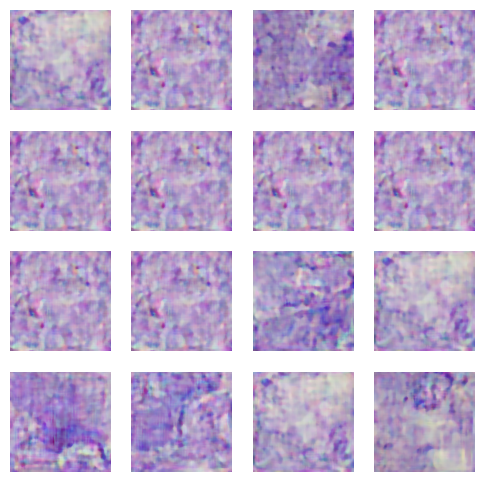

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

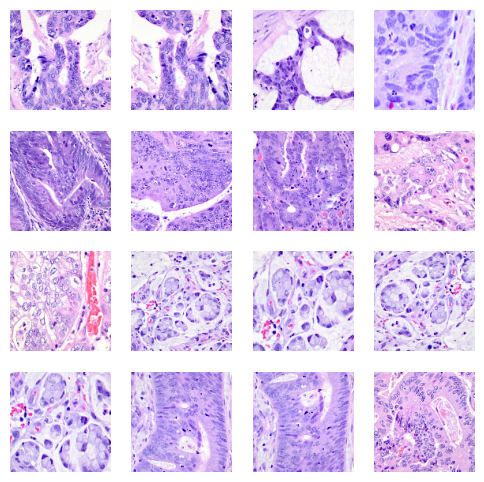

| It: 1 | Loss: -41.4931 | Time:   0.70s |


| It: 1001 | Loss: -60.6471 | Time: 651.89s |


| It: 2001 | Loss: -61.2549 | Time: 654.48s |


| It: 3001 | Loss: -61.4301 | Time: 651.38s |


| It: 4001 | Loss: -61.5561 | Time: 653.78s |


| It: 5001 | Loss: -61.6359 | Time: 654.46s |


| It: 6001 | Loss: -61.6919 | Time: 652.43s |


| It: 7001 | Loss: -61.7393 | Time: 655.32s |


| It: 8001 | Loss: -61.7703 | Time: 652.00s |


| It: 9001 | Loss: -61.7838 | Time: 654.49s |


| It: 1 | Loss: -42.9916 | Time:   0.68s |


| It: 1001 | Loss: -60.7665 | Time: 652.01s |


| It: 2001 | Loss: -61.2990 | Time: 654.35s |


| It: 3001 | Loss: -61.4885 | Time: 653.48s |


| It: 4001 | Loss: -61.5977 | Time: 652.22s |


| It: 5001 | Loss: -61.6720 | Time: 653.85s |


| It: 6001 | Loss: -61.7246 | Time: 654.13s |


| It: 7001 | Loss: -61.7636 | Time: 652.07s |


| It: 8001 | Loss: -61.7893 | Time: 654.92s |


| It: 9001 | Loss: -61.8030 | Time: 653.37s |


| It: 1 | Loss: -43.2275 | Time:   0.68s |


| It: 1001 | Loss: -60.5859 | Time: 654.60s |


| It: 2001 | Loss: -61.2078 | Time: 653.22s |


| It: 3001 | Loss: -61.4401 | Time: 652.36s |


| It: 4001 | Loss: -61.5616 | Time: 654.99s |


| It: 5001 | Loss: -61.6407 | Time: 653.90s |


| It: 6001 | Loss: -61.6965 | Time: 651.32s |


| It: 7001 | Loss: -61.7450 | Time: 643.65s |


| It: 8001 | Loss: -61.7733 | Time: 653.35s |


| It: 9001 | Loss: -61.7870 | Time: 652.36s |


| It: 1 | Loss: -44.4851 | Time:   0.68s |


| It: 1001 | Loss: -60.4164 | Time: 654.08s |


| It: 2001 | Loss: -61.1983 | Time: 650.72s |


| It: 3001 | Loss: -61.4227 | Time: 649.61s |


| It: 4001 | Loss: -61.5436 | Time: 649.80s |


| It: 5001 | Loss: -61.6323 | Time: 650.43s |


| It: 6001 | Loss: -61.6966 | Time: 652.36s |


| It: 7001 | Loss: -61.7421 | Time: 654.91s |


| It: 8001 | Loss: -61.7738 | Time: 653.51s |


| It: 9001 | Loss: -61.7873 | Time: 650.26s |


| It: 1 | Loss: -42.2503 | Time:   0.68s |


| It: 1001 | Loss: -60.5203 | Time: 654.63s |


| It: 2001 | Loss: -61.1854 | Time: 650.57s |


| It: 3001 | Loss: -61.4310 | Time: 654.39s |


| It: 4001 | Loss: -61.5685 | Time: 653.99s |


| It: 5001 | Loss: -61.6437 | Time: 650.04s |


| It: 6001 | Loss: -61.7046 | Time: 651.00s |


| It: 7001 | Loss: -61.7480 | Time: 654.86s |


| It: 8001 | Loss: -61.7787 | Time: 651.22s |


| It: 9001 | Loss: -61.7922 | Time: 648.66s |


BEST PSNR: 13.4508
MEDIAN PSNR: 12.1579
ALL PSNR: [13.4508, 11.4680, 12.4008, 12.8753, 12.8753]


<Figure size 400x300 with 0 Axes>

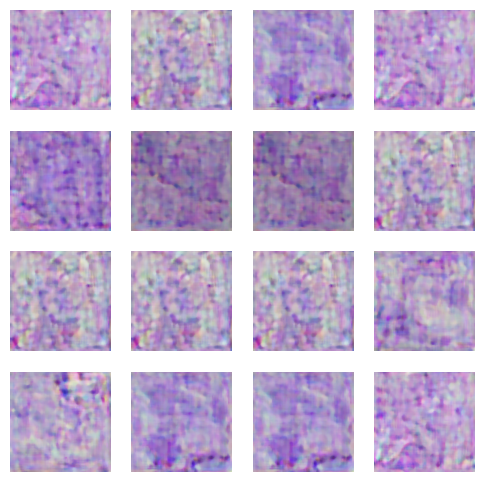

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

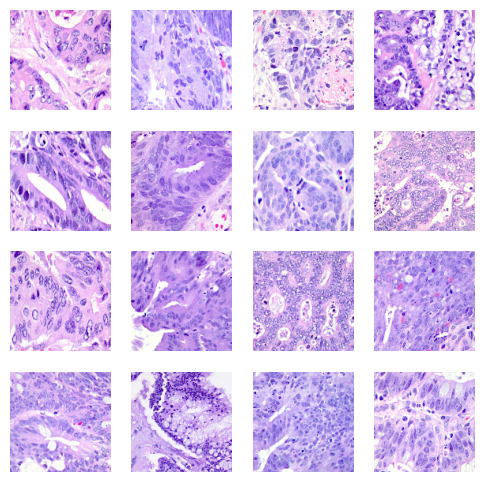

| It: 1 | Loss: -43.7240 | Time:   0.62s |


| It: 1001 | Loss: -60.7410 | Time: 651.03s |


| It: 2001 | Loss: -61.2822 | Time: 649.08s |


| It: 3001 | Loss: -61.4958 | Time: 652.83s |


| It: 4001 | Loss: -61.5997 | Time: 653.92s |


| It: 5001 | Loss: -61.6655 | Time: 649.44s |


| It: 6001 | Loss: -61.7182 | Time: 651.00s |


| It: 7001 | Loss: -61.7599 | Time: 653.93s |


| It: 8001 | Loss: -61.7867 | Time: 649.55s |


| It: 9001 | Loss: -61.8000 | Time: 648.74s |


| It: 1 | Loss: -42.4350 | Time:   0.66s |


| It: 1001 | Loss: -60.6556 | Time: 651.98s |


| It: 2001 | Loss: -61.2746 | Time: 648.60s |


| It: 3001 | Loss: -61.4903 | Time: 653.05s |


| It: 4001 | Loss: -61.5907 | Time: 653.55s |


| It: 5001 | Loss: -61.6611 | Time: 649.21s |


| It: 6001 | Loss: -61.7181 | Time: 650.08s |


| It: 7001 | Loss: -61.7579 | Time: 654.90s |


| It: 8001 | Loss: -61.7853 | Time: 651.57s |


| It: 9001 | Loss: -61.7972 | Time: 649.62s |


| It: 1 | Loss: -44.2845 | Time:   0.68s |


| It: 1001 | Loss: -60.6483 | Time: 652.24s |


| It: 2001 | Loss: -61.2758 | Time: 647.89s |


| It: 3001 | Loss: -61.4517 | Time: 648.05s |


| It: 4001 | Loss: -61.5772 | Time: 653.59s |


| It: 5001 | Loss: -61.6561 | Time: 650.38s |


| It: 6001 | Loss: -61.7058 | Time: 649.37s |


| It: 7001 | Loss: -61.7497 | Time: 653.87s |


| It: 8001 | Loss: -61.7778 | Time: 654.60s |


| It: 9001 | Loss: -61.7907 | Time: 645.52s |


| It: 1 | Loss: -41.4592 | Time:   0.67s |


| It: 1001 | Loss: -60.3816 | Time: 651.54s |


| It: 2001 | Loss: -61.0140 | Time: 654.83s |


| It: 3001 | Loss: -61.3516 | Time: 651.00s |


| It: 4001 | Loss: -61.5173 | Time: 649.99s |


| It: 5001 | Loss: -61.6091 | Time: 655.21s |


| It: 6001 | Loss: -61.6733 | Time: 652.90s |


| It: 7001 | Loss: -61.7244 | Time: 649.83s |


| It: 8001 | Loss: -61.7563 | Time: 651.88s |


| It: 9001 | Loss: -61.7702 | Time: 655.41s |


| It: 1 | Loss: -42.4990 | Time:   0.67s |


| It: 1001 | Loss: -60.3968 | Time: 649.16s |


| It: 2001 | Loss: -61.1471 | Time: 650.41s |


| It: 3001 | Loss: -61.3733 | Time: 655.36s |


| It: 4001 | Loss: -61.5198 | Time: 651.80s |


| It: 5001 | Loss: -61.6186 | Time: 649.15s |


| It: 6001 | Loss: -61.6854 | Time: 650.66s |


| It: 7001 | Loss: -61.7311 | Time: 655.34s |


| It: 8001 | Loss: -61.7645 | Time: 652.72s |


| It: 9001 | Loss: -61.7785 | Time: 650.23s |


BEST PSNR: 13.5756
MEDIAN PSNR: 13.0997
ALL PSNR: [12.7763, 13.5756, 13.2603, 13.1216, 13.1216]


<Figure size 400x300 with 0 Axes>

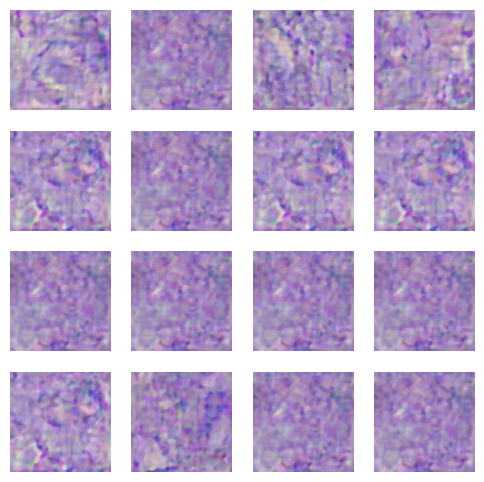

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

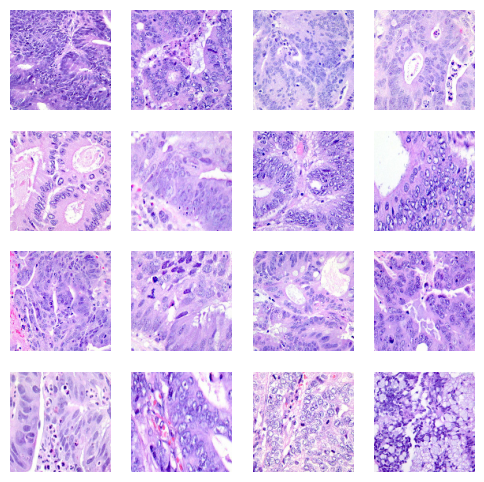

| It: 1 | Loss: -45.2545 | Time:   0.70s |


| It: 1001 | Loss: -60.7311 | Time: 652.73s |


| It: 2001 | Loss: -61.3046 | Time: 649.85s |


| It: 3001 | Loss: -61.4837 | Time: 648.46s |


| It: 4001 | Loss: -61.5984 | Time: 649.15s |


| It: 5001 | Loss: -61.6628 | Time: 654.32s |


| It: 6001 | Loss: -61.7276 | Time: 649.45s |


| It: 7001 | Loss: -61.7686 | Time: 648.00s |


| It: 8001 | Loss: -61.7965 | Time: 654.55s |


| It: 9001 | Loss: -61.8101 | Time: 653.03s |


| It: 1 | Loss: -45.2350 | Time:   0.67s |


| It: 1001 | Loss: -60.6904 | Time: 649.91s |


| It: 2001 | Loss: -61.3170 | Time: 654.99s |


| It: 3001 | Loss: -61.4973 | Time: 650.96s |


| It: 4001 | Loss: -61.6129 | Time: 648.53s |


| It: 5001 | Loss: -61.6851 | Time: 648.52s |


| It: 6001 | Loss: -61.7396 | Time: 654.20s |


| It: 7001 | Loss: -61.7782 | Time: 653.39s |


| It: 8001 | Loss: -61.8040 | Time: 650.09s |


| It: 9001 | Loss: -61.8171 | Time: 648.65s |


| It: 1 | Loss: -45.1067 | Time:   0.69s |


| It: 1001 | Loss: -60.8686 | Time: 654.36s |


| It: 2001 | Loss: -61.3523 | Time: 650.12s |


| It: 3001 | Loss: -61.5330 | Time: 649.54s |


| It: 4001 | Loss: -61.6211 | Time: 655.33s |


| It: 5001 | Loss: -61.6921 | Time: 652.38s |


| It: 6001 | Loss: -61.7462 | Time: 649.76s |


| It: 7001 | Loss: -61.7847 | Time: 652.49s |


| It: 8001 | Loss: -61.8110 | Time: 654.43s |


| It: 9001 | Loss: -61.8235 | Time: 650.86s |


| It: 1 | Loss: -46.0978 | Time:   0.67s |


| It: 1001 | Loss: -60.7754 | Time: 655.25s |


| It: 2001 | Loss: -61.3303 | Time: 652.69s |


| It: 3001 | Loss: -61.5319 | Time: 650.54s |


| It: 4001 | Loss: -61.6377 | Time: 655.27s |


| It: 5001 | Loss: -61.7015 | Time: 653.22s |


| It: 6001 | Loss: -61.7545 | Time: 650.35s |


| It: 7001 | Loss: -61.7908 | Time: 649.19s |


| It: 8001 | Loss: -61.8169 | Time: 652.11s |


| It: 9001 | Loss: -61.8267 | Time: 655.06s |


| It: 1 | Loss: -44.8530 | Time:   0.67s |


| It: 1001 | Loss: -60.9098 | Time: 649.78s |


| It: 2001 | Loss: -61.3681 | Time: 649.11s |


| It: 3001 | Loss: -61.5287 | Time: 654.01s |


| It: 4001 | Loss: -61.6268 | Time: 654.57s |


| It: 5001 | Loss: -61.6960 | Time: 651.24s |


| It: 6001 | Loss: -61.7478 | Time: 649.79s |


| It: 7001 | Loss: -61.7854 | Time: 649.41s |


| It: 8001 | Loss: -61.8117 | Time: 653.00s |


| It: 9001 | Loss: -61.8231 | Time: 655.16s |


BEST PSNR: 14.2658
MEDIAN PSNR: 13.8166
ALL PSNR: [13.7887, 14.1800, 13.0987, 13.7500, 13.7500]


<Figure size 400x300 with 0 Axes>

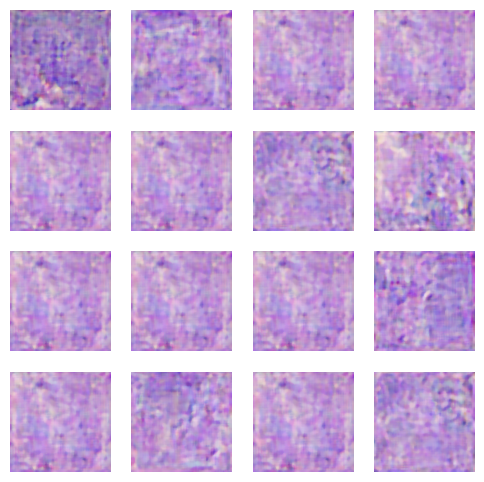

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)